# Project 3: Web APIs & NLP
# Notebook 5: Testing

https://github.com/pushshift/api<br>
https://api.pushshift.io/reddit/search/comment/

## Contents
- [Import Libraries and Data](#Import-Libraries-and-Data)
- [Create and Score Labeled Test Dataset](#Create-and-Score-Labeled-Test-Dataset)
- [Run the Model on the Libertarian Subreddit](#Run-the-Model-on-the-Libertarian-Subreddit)
- [Analyze Libertarian Subreddit Users](#Analyze-Libertarian-Subreddit-Users)
- [Examine Most Common Words in Each Subreddit](#Examine-Most-Common-Words-in-Each-Subreddit)
- [Summary and Further Research](#Summary-and-Further-Research)

## Import Libraries and Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

import pickle

from sklearn.metrics import (confusion_matrix, precision_score, recall_score, accuracy_score,
                             roc_auc_score, plot_confusion_matrix)

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 100)

In [7]:
df_p = pd.read_csv("../datasets/politics_subreddit_latest_6500_cleaned.csv", squeeze = True)
df_c = pd.read_csv("../datasets/conservative_subreddit_latest_6500_cleaned.csv", squeeze = True)
df_l = pd.read_csv("../datasets/libertarian_subreddit_latest_6500_cleaned.csv", squeeze = True)

In [8]:
X_train = pd.read_csv("../datasets/X_train", squeeze = True)
X_test = pd.read_csv("../datasets/X_test", squeeze = True)
y_train = pd.read_csv("../datasets/y_train", squeeze = True)
y_test = pd.read_csv("../datasets/y_test", squeeze = True)

In [37]:
sum(y_test)/len(y_test)
# percentage of liberals in test data

0.5089013224821973

In [9]:
vec_fitted = pickle.load(open('../models/vec_fitted.joblib', 'rb'))
X_train = vec_fitted.transform(X_train)
X_test = vec_fitted.transform(X_test)

ft = FunctionTransformer(lambda x: x.todense(), accept_sparse = True)
X_train = ft.fit_transform(X_train)
X_test = ft.transform(X_test)

best_model = pickle.load(open('../models/best_model.joblib', 'rb'))
print(best_model.score(X_train, y_train))
print(best_model.score(X_test, y_test))

0.8080921959163222
0.7011698880976602


## Create and Score Labeled Test Dataset

In [10]:
# # use this code for initial run of notebook, to generate test data:
# index_list = np.random.choice(df_l.index, size = 50, replace = False) 
# df_test = pd.DataFrame(df_l.loc[index_list, "body"])
# df_test.to_csv("../datasets/libertarian_subreddit_random_50_slants", index = False)

# use this code if reloading notebook, to load the test data:
df_test = pd.read_csv("../datasets/libertarian_subreddit_random_50_slants")

In [11]:
counter = 1
for i in range(0,len(df_test)):
    print(counter, df_test["body"].tolist()[i], "\n")
    counter += 1

1 I'm not dumbass I'm saying trump is straight up fucking hot garbage. 

2 the mods actively destroyed this sub they would sticky their political opinion in threads and prevent replies censor anything mentioning jews or blacks ban memes ban complaints about how shit the sub has become by making a metapost and demanding all critism of mods sub be confined to that one post place is a joke 

3 Not really as you contradicted yourself. What could be clearer than No 

4 Okay bootlicker who ironically says he opposes Nazis despite all of his comments carrying deeply fascistic overtones. 

5 These might help 1491 What do libertarians think of democracy quora.com 1175 Why do libertarians prefer the market to democracy quora.com 1062 Is democracy compatible with libertarianism quora.com 

6 You re kidding right There s a legitimate reason for people not to be out in public. Look at the number of people that are dying in NY. Yea the media is only talking about the virus shit because that s what p

In [12]:
# as before, 1 represents liberal and 0 represents conservative
# these values are my opinion on the political slant of the comments
slant_list = [1, 0, 0, 1, 1,  1, 1, 0, 0, 0, # 1-10
              1, 0, 1, 1, 1,  0, 0, 1, 1, 1, # 11-20
              0, 0, 0, 0, 0,  0, 0, 0, 1, 1, # 21-30
              1, 1, 0, 0, 0,  1, 1, 1, 0, 1, # 31-40
              1, 1, 0, 0, 0,  0, 0, 0, 0, 1] # 41-50

df_test["slant"] = slant_list

In [13]:
# baseline score
print(1 - sum(slant_list)/len(slant_list))

0.54


In [14]:
X_test_liber = df_test["body"]

X_test_liber = vec_fitted.transform(X_test_liber)

X_test_liber = ft.transform(X_test_liber)

df_test["predicted_slant"] = best_model.predict(X_test_liber)

y_test_liber = df_test["slant"]

# test score
print(best_model.score(X_test_liber, y_test_liber))

0.7


**The model was 16% more accurate than baseline (a model that guesses based on the majority percentage).**

In [15]:
# compare actual slants to what the model predicts
cm = confusion_matrix(df_test["slant"], df_test["predicted_slant"]) 
cm_df = pd.DataFrame(cm, columns = ["Predicted Conservative", "Predicted Liberal"], index = ["Actual Conservative", "Actual Liberal"])
cm_df

,Predicted Conservative,Predicted Liberal
Actual Conservative,24,3
Actual Liberal,12,11


In [16]:
tn, fp, fn, tp = confusion_matrix(df_test["slant"], df_test["predicted_slant"]).ravel()

In [17]:
print("Correctly Predicted Conservatives: %s" % tn)
print("Incorrectly Predicted Liberals: %s" % fp)
print("Incorrectly Predicted Conservatives: %s" % fn)
print("Correctly Predicted Liberals: %s" % tp)

Correctly Predicted Conservatives: 24
Incorrectly Predicted Liberals: 3
Incorrectly Predicted Conservatives: 12
Correctly Predicted Liberals: 11


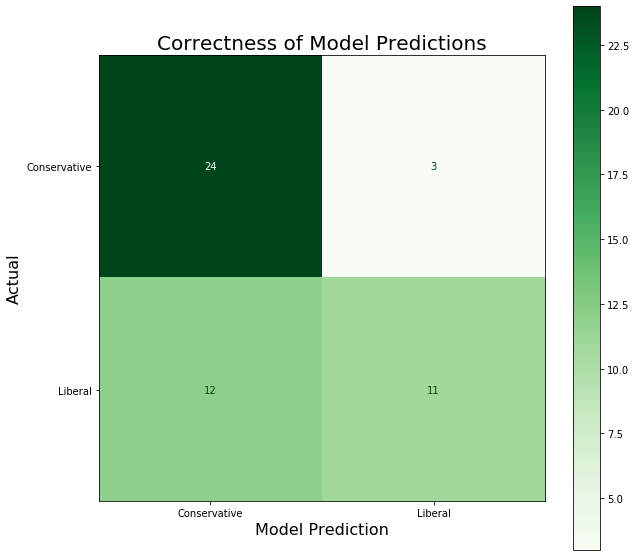

In [18]:
disp = plot_confusion_matrix(best_model, X_test_liber, y_test_liber, cmap = "Greens", values_format = ".3g",
                             display_labels = ["Conservative", "Liberal"])
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Correctness of Model Predictions', fontsize = 20)
plt.xlabel('Model Prediction', fontsize = 16)
plt.ylabel('Actual', fontsize = 16)
plt.show()

**The model mischaracterized 12 of 23 (52.2%) of liberals , and 3 of 27 (11.1%) of conservatives.**

In [19]:
df_test["probability_of_predictions"] = best_model.predict_proba(X_test_liber)[:,1]

In [20]:
roc_auc_score(df_test["slant"], df_test["probability_of_predictions"])

0.6360708534621577

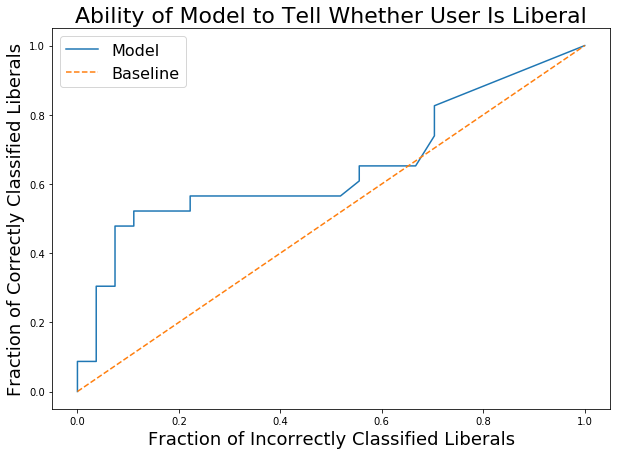

In [21]:
plt.figure(figsize = (10,7))

thresholds = np.linspace(0, 1, 200)

# sensitivity (true positive rate)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# 1 - specificity (false positive rate)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# sensitivity & 1 - specificity for each threshold between 0 and 1
tpr_values = [TPR(df_test, 'slant', 'probability_of_predictions', prob) for prob in thresholds]
fpr_values = [FPR(df_test, 'slant', 'probability_of_predictions', prob) for prob in thresholds]

# ROC curve for liberals
plt.plot(fpr_values, # false positive rate on X-axis
         tpr_values, # true positive rate on Y-axis
         label = 'Model')

# baseline (perfect overlap between the two populations)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label = 'Baseline',
         linestyle = '--')

plt.title('Ability of Model to Tell Whether User Is Liberal', fontsize = 22)
plt.ylabel('Fraction of Correctly Classified Liberals', fontsize = 18)
plt.xlabel('Fraction of Incorrectly Classified Liberals', fontsize = 18)

plt.legend(fontsize = 16);

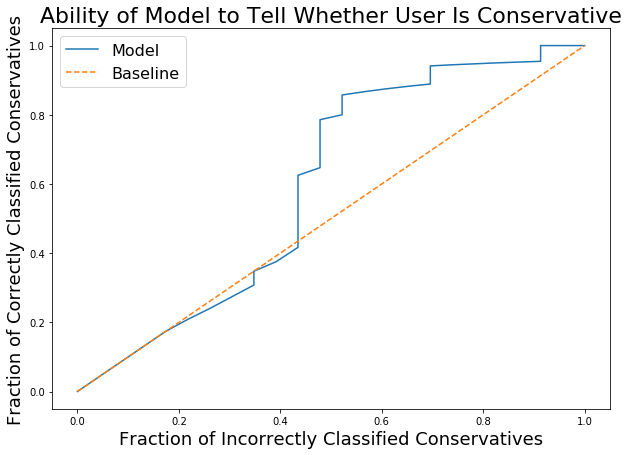

In [22]:
plt.figure(figsize = (10,7))

thresholds = np.linspace(0, 1, 200)

# specificity (true negative rate)
def TNR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 1) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return true_negative / (true_negative + false_positive)
    

# 1 - sensitivity (false negative rate)
def FNR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return 1 - (true_positive / (true_positive + false_negative))
    
# sensitivity & 1 - specificity for each threshold between 0 and 1
tnr_values = [TNR(df_test, 'slant', 'probability_of_predictions', prob) for prob in thresholds]
fnr_values = [FNR(df_test, 'slant', 'probability_of_predictions', prob) for prob in thresholds]

# ROC curve for conservatives
plt.plot(fnr_values, # false positive rate on X-axis
         tnr_values, # true positive rate on Y-axis
         label = 'Model')

# baseline (perfect overlap between the two populations)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label = 'Baseline',
         linestyle = '--')

plt.title('Ability of Model to Tell Whether User Is Conservative', fontsize = 22)
plt.ylabel('Fraction of Correctly Classified Conservatives', fontsize = 18)
plt.xlabel('Fraction of Incorrectly Classified Conservatives', fontsize = 18)

plt.legend(fontsize = 16);

**The AUC score is .636 (compared to a maximum of 1, a baseline of 0.5, and a minimum of 0).**<br>
**The words used by the liberal libertarians and the words used by the conservative libertarians in the model have significant overlap.**<br>
**The model is noticeably better than random guessing.**

## Run the Model on the Libertarian Subreddit

In [23]:
df_l

,subreddit,subreddit_id,author,author_fullname,body
0,Libertarian,t5_2qh63,mc2222,t2_5nnka,gt People have a right to go out into public a...
1,Libertarian,t5_2qh63,certifus,t2_883if,I'm more red than blue on this issue. The ques...
2,Libertarian,t5_2qh63,Maxdpage,t2_2epv03j9,I completely agree 330 Million is also close t...
3,Libertarian,t5_2qh63,FrenchLlamas,t2_5ko8sd21,You're not an internet moron if you don't feel...
4,Libertarian,t5_2qh63,Arkansas_Red,t2_14c6r0,Finally someone who can read
...,...,...,...,...,...
6465,Libertarian,t5_2qh63,GppDNAppA,t2_ucvca,There are a lot of different arguments in that...
6466,Libertarian,t5_2qh63,howmanypintobeans,t2_mjb66su,Trump is a total douchebag but he doesn t have...
6467,Libertarian,t5_2qh63,BriefingScree,t2_147g3w,They can require residency. Canadian provinces...
6468,Libertarian,t5_2qh63,MrStkrdknmibalzz,t2_28zy2z74,Lmao wow you really thought you were going to ...


In [24]:
X_liber = df_l["body"]

X_liber = vec_fitted.transform(X_liber)

X_liber = ft.transform(X_liber)

df_l["predicted_slant"] = best_model.predict(X_liber)

df_l["probability_of_predictions"] = best_model.predict_proba(X_liber)[:,1]

In [32]:
df_l["predicted_slant"].value_counts(normalize = True)

0    0.704328
1    0.295672
Name: predicted_slant, dtype: float64

## Analyze Libertarian Subreddit Users

In [26]:
user_views = pd.DataFrame(df_l.groupby("author")["predicted_slant"].mean())

In [27]:
predicted_slant_binary = []
for i in range(0,len(user_views)):
    if user_views.iloc[i,0] >= 0.5:
        predicted_slant_binary.append(1)
    else:
        predicted_slant_binary.append(0)
user_views["predicted_slant_binary"] = predicted_slant_binary

In [28]:
1-user_views["predicted_slant_binary"].mean()

0.6446862996158771

**35.5% of libertarian users leaned liberal, and 64.5% leaned conservative**

## Examine Most Common Words in Each Subreddit

**(Excluding words so common that they're in more than 1% of comments in that subreddit.)**

In [39]:
X_p = pd.read_csv("../datasets/politics_subreddit_latest_6500_cleaned.csv", squeeze = True)["body"]
cvec_p = CountVectorizer(max_features = 100, ngram_range = (1,1), max_df = .01)
cvec_p.fit(X_p)
X_p = cvec_p.transform(X_p)

feature_array_p = np.array(cvec_p.get_feature_names())
vec_sorting_p = np.argsort(X_p.toarray()).flatten()[::-1]

n = 25
top_n_p = feature_array_p[vec_sorting_p][:n]
top_n_p

array(['yet', 'fucked', 'days', 'death', 'different', 'donald', 'easy',
       'economy', 'elections', 'entire', 'fine', 'fox', 'full', 'white',
       'given', 'god', 'gop', 'guns', 'hate', 'healthcare', 'honestly',
       'impeachment', 'insurance', 'jared', 'course'], dtype='<U11')

In [40]:
X_c = pd.read_csv("../datasets/conservative_subreddit_latest_6500_cleaned.csv", squeeze = True)["body"]
cvec_c = CountVectorizer(max_features = 100, ngram_range = (1,1), max_df = .01)
cvec_c.fit(X_c)
X_c = cvec_c.transform(X_c)

feature_array_c = np.array(cvec_c.get_feature_names())
vec_sorting_c = np.argsort(X_c.toarray()).flatten()[::-1]

n = 25
top_n_c = feature_array_c[vec_sorting_c][:n]
top_n_c

array(['york', 'gets', 'dying', 'each', 'essential', 'except', 'experts',
       'face', 'family', 'fauci', 'fever', 'force', 'global', 'willing',
       'god', 'goes', 'guys', 'hell', 'higher', 'hospital', 'id',
       'information', 'laws', 'liberty', 'dont'], dtype='<U14')

In [41]:
X_l = pd.read_csv("../datasets/libertarian_subreddit_latest_6500_cleaned.csv", squeeze = True)["body"]
cvec_l = CountVectorizer(max_features = 100, ngram_range = (1,1), max_df = .01)
cvec_l.fit(X_l)
X_l = cvec_l.transform(X_l)

feature_array_l = np.array(cvec_l.get_feature_names())
vec_sorting_l = np.argsort(X_l.toarray()).flatten()[::-1]

n = 25
top_n_l = feature_array_l[vec_sorting_l][:n]
top_n_l

array(['italy', 'paid', 'worst', 'gouging', 'data', 'deal', 'demand',
       'distancing', 'doctor', 'effective', 'essential', 'false', 'goes',
       'gun', 'grocery', 'lower', 'haven', 'her', 'idiot', 'idiots',
       'industry', 'land', 'large', 'liberty', 'cost'], dtype='<U11')

## Summary and Further Research

- The model is noticeably more effective than guessing:
    - The model correctly recognizes comments from self-identified liberals and conservatives 70% of the time.
    - Guessing liberal based on the majority would be correct 51% of the time.
    - The model correctly recognizes comments from liberals and conservatives among self-identified libertarians 70% of the time.
    - Guessing conservative based on the majority would be correct 54% of the time. 
- The words used by the liberal libertarians and the conservative libertarians in the model had significant overlap:
    - An AUC score of 1 would mean the model can always tell apart liberals and conservatives, and an AUC score of 0.5 would mean model can't tell them apart at all. This model had an AUC score of 0.636.
- Out of the users that left the comments, 35.5% leaned liberal and 64.5% leaned conservative
- Liberal, conservative, and libertarian commenters have characteristic words:
    - Liberal: 'yet', 'fucked', 'days', 'death', 'different', 'donald', 'easy',
       'economy', 'elections', 'entire', 'fine', 'fox', 'full', 'white',
       'given', 'god', 'gop', 'guns', 'hate', 'healthcare'
    - Conservative: '[new] york', 'gets', 'dying', 'each', 'essential', 'except', 'experts',
       'face', 'family', 'fauci', 'fever', 'force', 'global', 'willing',
       'god', 'goes', 'guys', 'hell', 'higher', 'hospital'
    - Libertarian: 'italy', 'paid', 'worst', 'gouging', 'data', 'deal', 'demand',
       'distancing', 'doctor', 'effective', 'essential', 'false', 'goes',
       'gun', 'grocery', 'lower', 'haven'[t], 'her', 'idiot', 'idiots'
- All users have to log in to post comments, and logged in users see targeted ads
- This model could be used to target candidate ads to libertarian users to sway them in the elections
- Targeting ads towards libertarian users based on their comments would be more effective than paying for random ads
- Further areas of optimization:
    - Include far-right and far-left subreddit comment data for training the model
    - Tune more hyperparameters of the model, such as the maximum frequency of filler words (stop words) in the data
    - Crowd-source data on political slant by comment for the training dataset, instead of assuming that self-identified conservatives and liberals are conservative and liberal, respectively